## LOFO(Leave One Feature Out) Importance
https://github.com/aerdem4/lofo-importance

- 기존 Feature Importance, Permutation Feature Importance의 단점 보완
- Granular feature의 중요도가 과대평가 되지 않음
- 일반화 성능 우수
- 모델에 상관없이 사용 가능
- 성능을 저하 시키는 feature 경우 중요도가 음수로 계산됨
- feature를 그룹으로 묶을 수 있음. One-hot-encoding, TFIDF의 경우 유용
- 상관관계가 강한 feature들끼리 자동으로 묶을 수 있음

In [ ]:
# !pip install lofo-importance

In [1]:
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.datasets import fetch_california_housing

c:\Users\drago\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [36]:
dataset = fetch_california_housing()
raw_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
raw_df['target'] = dataset.target
raw_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [59]:
def df_process(df) :
    # AveBedrms 구간별 범주화
    bedroom_bins = [0, 1, 1.5, 2, 100]
    df['bedroom_bin'] = pd.cut(x=df['AveBedrms'], bins=bedroom_bins,
                               right=False, labels=range(len(bedroom_bins)-1))
    df = pd.get_dummies(df, columns=['bedroom_bin'])
    
    # AveOccup 반올림
    df['medinc_round'] = df['MedInc'].round()
    
    df = df.drop(columns=['AveBedrms', 'Latitude', 'Longitude'])
    
    return df
    

In [60]:
df = df_process(raw_df)
df

,MedInc,HouseAge,AveRooms,Population,AveOccup,target,bedroom_bin_0,bedroom_bin_1,bedroom_bin_2,bedroom_bin_3,medinc_round
0,8.3252,41.0,6.984127,322.0,2.555556,4.526,0,1,0,0,8.0
1,8.3014,21.0,6.238137,2401.0,2.109842,3.585,1,0,0,0,8.0
2,7.2574,52.0,8.288136,496.0,2.802260,3.521,0,1,0,0,7.0
3,5.6431,52.0,5.817352,558.0,2.547945,3.413,0,1,0,0,6.0
4,3.8462,52.0,6.281853,565.0,2.181467,3.422,0,1,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,845.0,2.560606,0.781,0,1,0,0,2.0
20636,2.5568,18.0,6.114035,356.0,3.122807,0.771,0,1,0,0,3.0
20637,1.7000,17.0,5.205543,1007.0,2.325635,0.923,0,1,0,0,2.0
20638,1.8672,18.0,5.329513,741.0,2.123209,0.847,0,1,0,0,2.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   Population     20640 non-null  float64
 4   AveOccup       20640 non-null  float64
 5   target         20640 non-null  float64
 6   bedroom_bin_0  20640 non-null  uint8  
 7   bedroom_bin_1  20640 non-null  uint8  
 8   bedroom_bin_2  20640 non-null  uint8  
 9   bedroom_bin_3  20640 non-null  uint8  
 10  medinc_round   20640 non-null  float64
dtypes: float64(7), uint8(4)
memory usage: 1.2 MB


- df : pandas DataFrame
- target : df에 포함된 target feature의 이름
- cv : cv generator
  - 참고 : sklearn.model_selection.cross_validate의 paramter중 cv
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
- metric : 성능 지표
  - `sklearn.metrics.get_scorer_names()` 목록 중 고르거나 custom metric 함수 사용 가능
- model : 없으면 LGBMClassifier/LGBMRegressor

In [92]:
def get_lofo_importance(df, target, cv, metric, model=None, groups=list(), corr_threshold=1) :
    # Dataset 생성
    # df : target이 포함된 DataFrame
    # target : target feature 이름
    # features : target 제외한 feature 이름을 담은 list
    features = list(set(df.columns) - {'target'} - set(groups))
    if groups :
        feature_groups = {'bin_feautres' : df[groups].values}
    else :
        feature_groups = None
    lofo_dataset = Dataset(df=df, target=target,
                    features=features,
                    feature_groups=feature_groups, auto_group_threshold=corr_threshold)

    # LOFOImportance 생성
    # dataset : LOFO Datset 객체
    # cv : cv generator (KFold 등)
    # scoring : metric
    # model : default=LGBMClassifier/LGBMRegressor
    if not model :
        lofo_imp = LOFOImportance(dataset=lofo_dataset, cv=cv, scoring=metric)
    if model :
        lofo_imp = LOFOImportance(dataset=lofo_dataset, model=model, cv=cv, scoring=metric)

    # get the mean and standard deviation of the importances in pandas format
    importance_df = lofo_imp.get_importance()

    # plot the means and standard deviations of the importances
    print(f">>>>>{model.__class__.__name__}<<<<<")
    plot_importance(importance_df, figsize=(12, 5))
    return importance_df

  0%|          | 0/10 [00:00<?, ?it/s]

>>>>>NoneType<<<<<


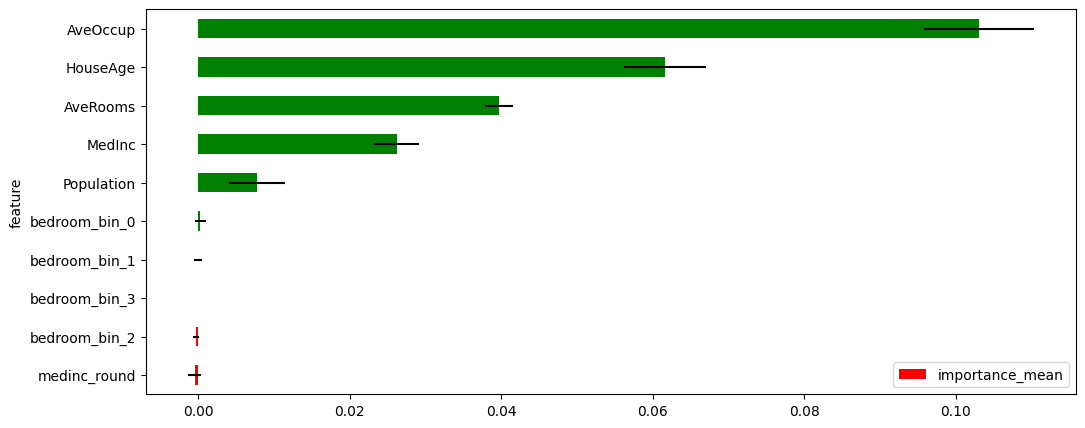

In [93]:
target = 'target'
cv = KFold(n_splits=5, shuffle=True, random_state=42)
metric = 'neg_mean_squared_error'
# model = LGBMRegressor(max_depth=10, learning_rate=0.01, n_estimators=1000, random_state=42)
# model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)


lofo_importance_df = get_lofo_importance(df=df, target='target', cv=cv, metric=metric)

  0%|          | 0/7 [00:00<?, ?it/s]

>>>>>NoneType<<<<<


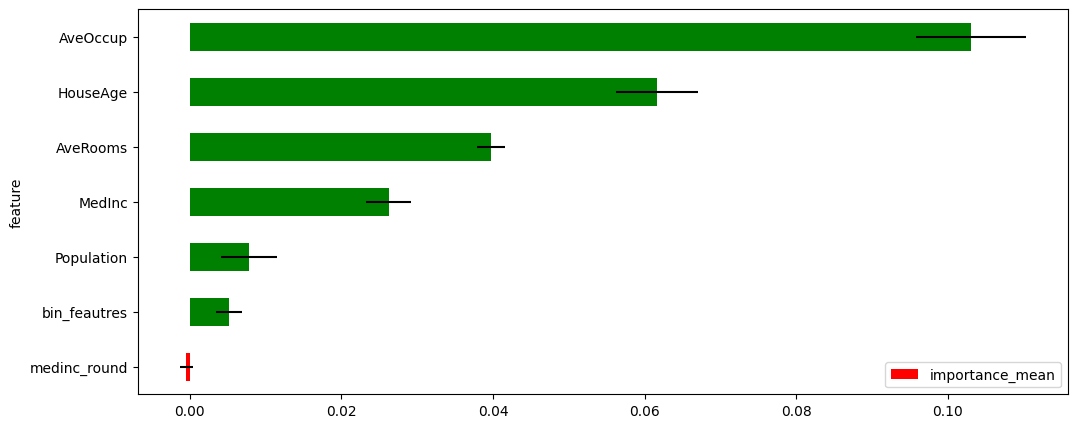

In [94]:
groups = list(df.columns[6:10])

lofo_importance_df_2 = get_lofo_importance(df=df, target='target', cv=cv, metric=metric,
                                           groups=groups)

Automatically grouped features by correlation:
1 ['MedInc', 'medinc_round']
2 ['bedroom_bin_0', 'bedroom_bin_1']


  0%|          | 0/8 [00:00<?, ?it/s]

>>>>>NoneType<<<<<


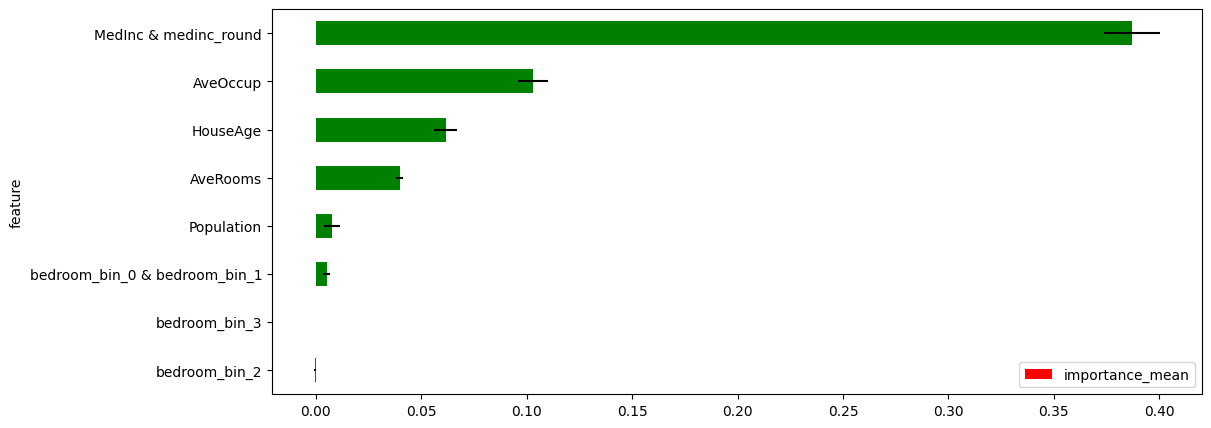

In [95]:
corr_threshold=0.9

lofo_importance_df_3 = get_lofo_importance(df=df, target='target', cv=cv, metric=metric,
                                           corr_threshold=corr_threshold)